1) Przypomnienie zwykłego clusteringu
* k-means
* PAM?

2) Co to jest ensamble clustering
* Generation step
* Consensus step
* Cechy dobrego modelu

3) Przykładowe modele

4) Case study

In [120]:
from sklearn.cluster import KMeans, MiniBatchKMeans, SpectralClustering
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.datasets import make_moons, make_blobs
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

# Dataset creation

In [52]:
def plot_points(dataset, labels=None):
    if labels is None:
        labels = 'cornflowerblue'
    plt.figure(figsize=(8, 8))
    plt.grid(alpha=0.4)
    plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap='tab20')
    # plt.xticks([])
    # plt.yticks([])
    
    plt.show()

(500, 2)


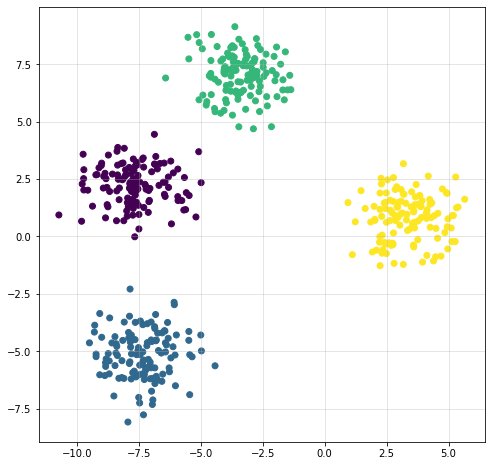

In [3]:
dataset_easy, labels = make_blobs(n_samples=500, n_features=2, centers=4, random_state=43)
print(dataset_easy.shape)
plot_points(dataset_easy, labels)

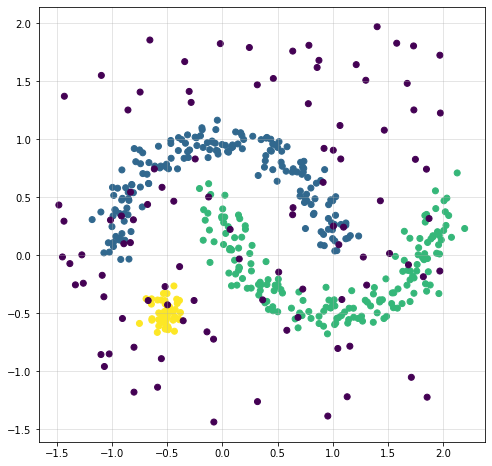

In [4]:
np.random.seed(214)

X_moons, y1 = make_moons(n_samples=350, noise=0.1, random_state=214)
X_blobs, y2 = make_blobs(n_samples=50, centers=[[-0.5,-0.5]], cluster_std=[0.1], random_state=214)
y2 += 2
X_noise = np.random.uniform(low=-1.5, high=2.0, size=(100,2))

dataset_hard = np.vstack([X_moons, X_blobs, X_noise])
labels = np.concatenate([y1, y2, -np.ones(100)])
plot_points(dataset_hard, labels)

(500, 2)


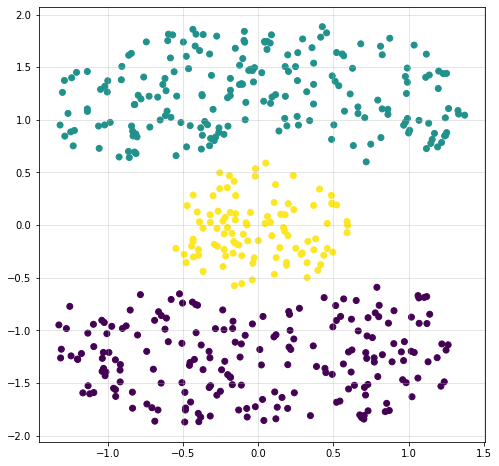

In [6]:
dataset_cassini = np.loadtxt('Data/cassini.csv', delimiter=';')
labels = np.loadtxt('Data/cassini_labels.csv')
print(dataset_cassini.shape)
plot_points(dataset_cassini, labels)

In [53]:
def plot_three_datasets(labels1, labels2, labels3, dataset1=dataset_easy, dataset2=dataset_hard, dataset3=dataset_cassini):
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.grid(alpha=0.4)
    plt.scatter(dataset1[:, 0], dataset1[:, 1], c=labels1, cmap='tab20')
    plt.title("Easy Dataset")
    
    plt.subplot(1, 3, 2)
    plt.grid(alpha=0.4)
    plt.scatter(dataset2[:, 0], dataset2[:, 1], c=labels2, cmap='tab20')
    plt.title("Hard Dataset")
    
    plt.subplot(1, 3, 3)
    plt.grid(alpha=0.4)
    plt.scatter(dataset3[:, 0], dataset3[:, 1], c=labels3, cmap='tab20')
    plt.title("Cassini Dataset")
    
    plt.show()

c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\kaami\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


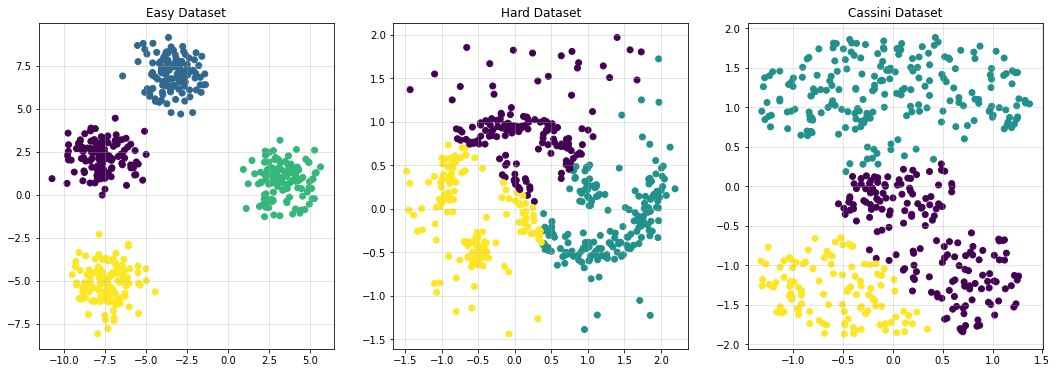

In [8]:
parameters = {'n_init': 10, 'max_iter': 300}
D1 = KMeans(n_clusters=4, **parameters).fit(dataset_easy).labels_
D2 = KMeans(n_clusters=3, **parameters).fit(dataset_hard).labels_
D3 = KMeans(n_clusters=3, **parameters).fit(dataset_cassini).labels_

plot_three_datasets(D1, D2, D3)

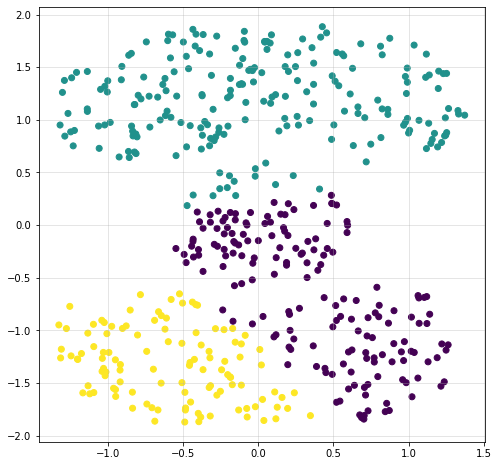

In [9]:
plot_points(dataset_cassini, D3)

In [ ]:
class ClusterSimilarityMatrix():
    def __init__(self) -> None:
        self._is_fitted = False

    def fit(self, y_clusters):
        if not self._is_fitted:
            self._is_fitted = True
            self.similarity = self.to_binary_matrix(y_clusters)
            return self

        self.similarity += self.to_binary_matrix(y_clusters)

    def to_binary_matrix(self, y_clusters):
        y_reshaped = np.expand_dims(y_clusters, axis=-1)
        return (cdist(y_reshaped, y_reshaped, 'cityblock')==0).astype(int)

# First method

In [114]:
#https://medium.com/@nielsencastelodamascenodantas/clustering-ensamble-f810fd81deaf
class EnsembleSpectralClustering():
    def __init__(self, clusters_number, base_estimator, base_estimator_num_clusters, estimators_num=100, parameters={}):
        self.clusters_number = clusters_number
        self.base_estimator_num_clusters = base_estimator_num_clusters
        self.estimators_num= estimators_num
        self.clustering_models = self.estimators_num*[base_estimator(n_clusters=self.base_estimator_num_clusters, n_init=1, init = 'random', **parameters)]
        
    def fit(self, X):
        clt_sim_matrix = ClusterSimilarityMatrix()
        for model in self.clustering_models:
            clt_sim_matrix.fit(model.fit(X).labels_)
            
        sim_matrix = clt_sim_matrix.similarity
        norm_sim_matrix = sim_matrix/sim_matrix.diagonal()
        
        spec_clt = SpectralClustering(n_clusters=self.clusters_number, affinity='precomputed')
        return spec_clt.fit_predict(norm_sim_matrix)

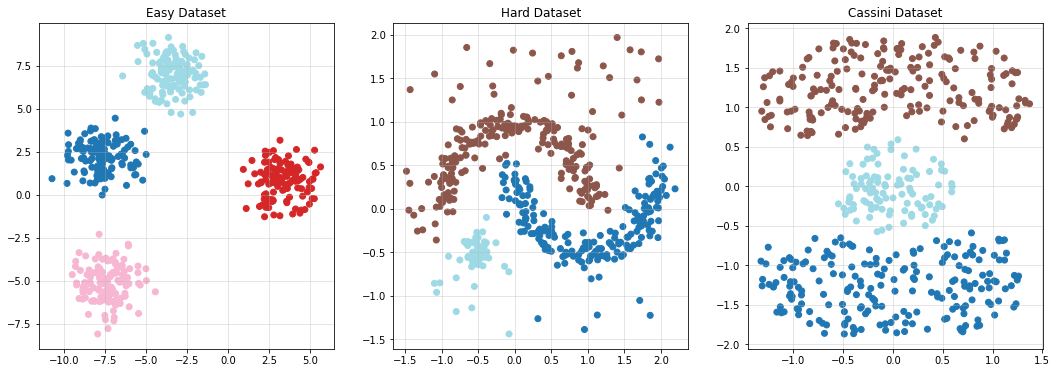

In [118]:
modelD1 = EnsembleSpectralClustering(clusters_number=4,
                                     base_estimator=MiniBatchKMeans,
                                     base_estimator_num_clusters = 20)
modelD2 = EnsembleSpectralClustering(clusters_number=3,
                                     base_estimator=MiniBatchKMeans,
                                     base_estimator_num_clusters = 20)
modelD3 = EnsembleSpectralClustering(clusters_number=3,
                                     base_estimator=MiniBatchKMeans,
                                     base_estimator_num_clusters = 20)

y1 = modelD1.fit(dataset_easy)
y2 = modelD2.fit(dataset_hard)
y3 = modelD3.fit(dataset_cassini)

plot_three_datasets(y1, y2, y3)

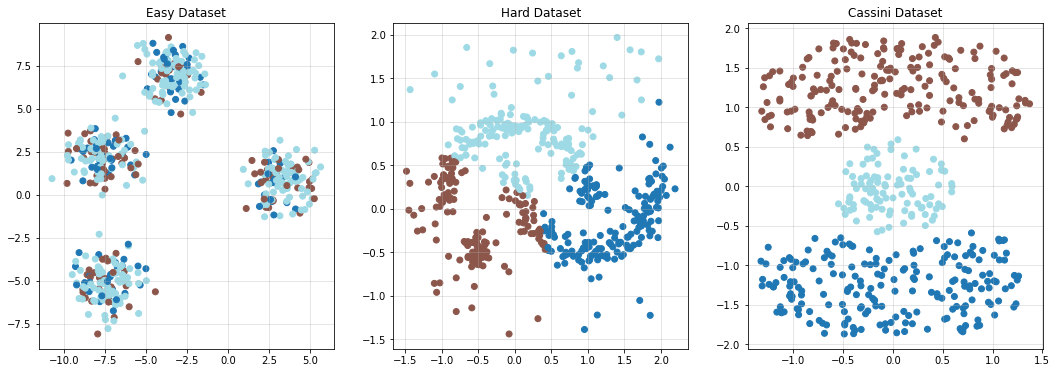

In [119]:
y1 = SpectralClustering(n_clusters=4).fit_predict(dataset_easy)
y2 = SpectralClustering(n_clusters=3).fit_predict(dataset_hard)
y1 = SpectralClustering(n_clusters=3).fit_predict(dataset_cassini)
plot_three_datasets(y1, y2, y3)


# Second method

In [34]:
# https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265
class GraphConnected():
    def __init__(self, estimator, clusters_number, estimators_num, min_probability, estimator_parameters):
        self.n_clusters = clusters_number
        self.estimator_parameters = estimator_parameters
        self.estimators_num = estimators_num
        self.min_probability = min_probability
        self.clustering_models = self.estimators_num*[estimator(n_clusters = self.n_clusters, **self.estimator_parameters)]
        
    def fit(self, X):
        clt_sim_matrix = ClusterSimilarityMatrix()
        for model in self.clustering_models:
            clt_sim_matrix.fit(model.fit(X).labels_)
            
        sim_matrix = clt_sim_matrix.similarity
        norm_sim_matrix = sim_matrix/sim_matrix.diagonal()
        
        graph = (norm_sim_matrix>self.min_probability).astype(int)
        
        n_clusters, y_ensemble = connected_components(graph, directed=False, return_labels=True)
        
        return y_ensemble

In [77]:
modelD1 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=16,
                       min_probability=0.6,
                       estimator_parameters=parameters)
modelD2 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=16,
                       min_probability=0.6,
                       estimator_parameters=parameters)
modelD3 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=16,
                       min_probability=0.6,
                       estimator_parameters=parameters)

In [78]:
y1 = modelD1.fit(dataset_easy)
y2 = modelD2.fit(dataset_hard)
y3 = modelD3.fit(dataset_cassini)

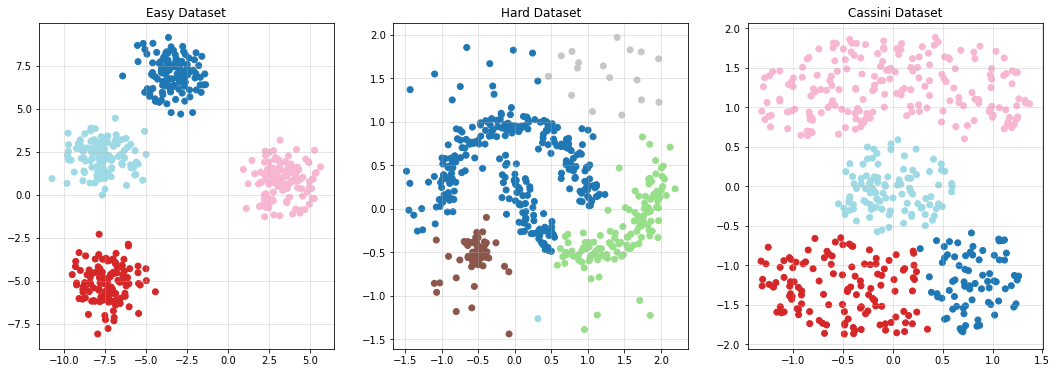

In [79]:
plot_three_datasets(y1, y2, y3)

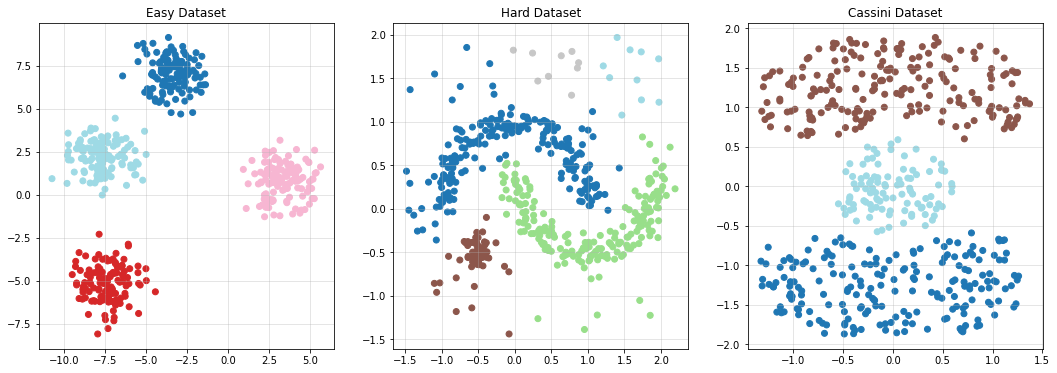

In [70]:
modelD1 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=16,
                       estimators_num=32,
                       min_probability=0.5,
                       estimator_parameters=parameters)
modelD2 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=16,
                       estimators_num=32,
                       min_probability=0.6,
                       estimator_parameters=parameters)
modelD3 = GraphConnected(estimator=MiniBatchKMeans,
                       clusters_number=8,
                       estimators_num=32,
                       min_probability=0.6,
                       estimator_parameters=parameters)

y1 = modelD1.fit(dataset_easy)
y2 = modelD2.fit(dataset_hard)
y3 = modelD3.fit(dataset_cassini)

plot_three_datasets(y1, y2, y3)

# Third method

In [121]:
class BaggedMajority():
    def __init__(self, clusters, params, num_of_partitions=100, base_estimator=KMeans):
        self.clusters = clusters
        self.num_of_partitions = num_of_partitions
        self.base_estimator = base_estimator
        self.params = params
        
    @staticmethod
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)

        
    def fit(self, X):
        nrow, ncol = X.shape
        indices = np.arange(0, nrow)
        initial_labels = self.base_estimator(**self.params).fit(X).labels_
        Y = np.zeros((nrow, self.clusters))
        for b in range(self.num_of_partitions):
            sample_indices = np.random.randint(0, nrow, nrow)
            intersect = np.intersect1d(indices, sample_indices)
            new_X = X[sample_indices]
            new_labels = self.base_estimator(**self.params).fit(new_X).labels_
            relabel = -np.ones(nrow, dtype=int)
            relabel[sample_indices] = new_labels
            common_labels_1, common_labels_2 = initial_labels[intersect], relabel[intersect]
            cm = confusion_matrix(common_labels_1, common_labels_2)
            a, b = list(map(list, linear_sum_assignment(self._make_cost_m(cm))))
            after_assignment = [a[b.index(i)] for i in common_labels_2]
            Y[intersect, after_assignment] += 1
        problematic = (Y.mean(axis=1) == 0)
        final_result = Y.argsort(axis=1)[:, ::-1][:, 0]
        final_result[problematic] = initial_labels[problematic]
        self.labels_ = final_result
        return final_result

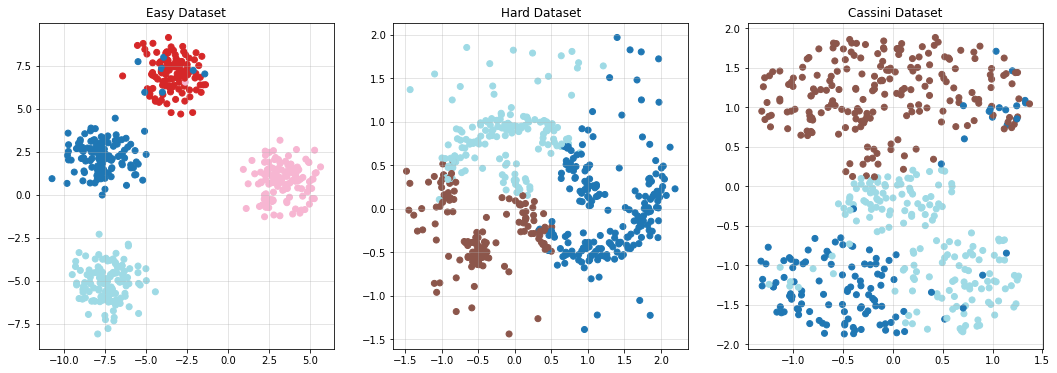

In [130]:
modelD1 = BaggedMajority(clusters=4, num_of_partitions=30,base_estimator=MiniBatchKMeans,
                        params={"n_clusters": 4, "init": "random", "n_init": 1})
modelD2 = BaggedMajority(clusters=3, num_of_partitions=30, base_estimator=MiniBatchKMeans,
                        params={"n_clusters": 3, "init": "random", "n_init": 1})
modelD3 = BaggedMajority(clusters=3, num_of_partitions=30,base_estimator=MiniBatchKMeans,
                        params={"n_clusters": 3, "init": "random", "n_init": 1})

y1 = modelD1.fit(dataset_easy)
y2 = modelD2.fit(dataset_hard)
y3 = modelD3.fit(dataset_cassini)

plot_three_datasets(y1, y2, y3)